In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.applications.resnet50 import preprocess_input
import mediapipe as mp

Imagen de prueba

In [26]:
# Ruta de la imagen
img_path = r"images\imagenes_MVP\WhatsApp Image 2024-10-21 at 21.03.41.jpeg"

# Leer la imagen
img = cv2.imread(img_path)

## Preprocesamiento

Detección y recorte Mediapipe

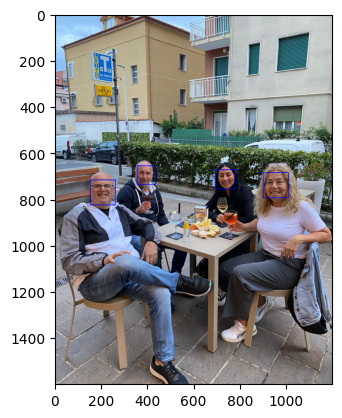

In [ ]:
# Inicializa MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Convierte la imagen a RGB (MediaPipe espera imágenes en RGB)
img = cv2.imread(img_path)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Inicializa el detector de rostros de MediaPipe
with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.7) as face_detection:
    # Procesa la imagen
    results = face_detection.process(rgb_img)

# Lista para almacenar las coordenadas de los rostros
faces = []

# Verifica si se detectaron rostros
if results.detections:
    for detection in results.detections:
        # Obtiene las coordenadas del bounding box
        bboxC = detection.location_data.relative_bounding_box
        ih, iw, _ = img.shape
        x = int(bboxC.xmin * iw)
        y = int(bboxC.ymin * ih)
        w = int(bboxC.width * iw)
        h = int(bboxC.height * ih)
        # Guarda las coordenadas en el formato (x, y, w, h)
        faces.append((x, y, w, h))
        # Dibuja un rectángulo alrededor del rostro detectado
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Muestra la imagen con los rostros detectados
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


Defino una función para preprocesamiento de los rostros

In [24]:
# Definir la función para preprocesar la cara
def preprocess_face(face_img):
    # Redimensionar la cara al tamaño requerido por el modelo
    face_resized = cv2.resize(face_img, (224, 224))
    
    # Convertir la imagen a formato array y preprocesar (según el modelo)
    face_array = np.array(face_resized)
    
    # Expandir las dimensiones para que tenga el formato (1, 224, 224, 3)
    face_array = np.expand_dims(face_array, axis=0)
    
    # Aplicar la preprocesación de ResNet50
    face_preprocessed = preprocess_input(face_array)
    
    return face_preprocessed

## Usar modelos guardados como .pd 

In [25]:
model_path = "models/ResNet50_classification_model"
custom_model = keras.layers.TFSMLayer(model_path, call_endpoint='serving_default')

In [26]:
names = ["1.niños", "2.adolescentes", "3.jovenes_adultos", "4.adultos", "5.adultos_mayores", "6.tercera_edad"]

{'output_0': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.00511124, 0.02622214, 0.03020995, 0.02623943, 0.13328075,
        0.77893645]], dtype=float32)>}


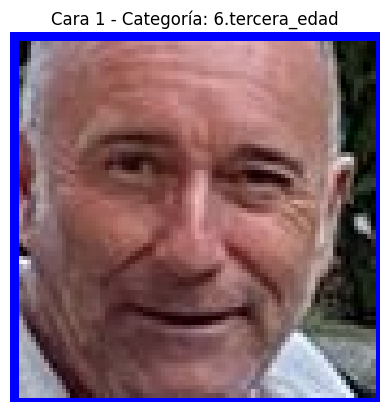

{'output_0': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.07732845, 0.37501654, 0.11006765, 0.18610026, 0.13327263,
        0.1182144 ]], dtype=float32)>}


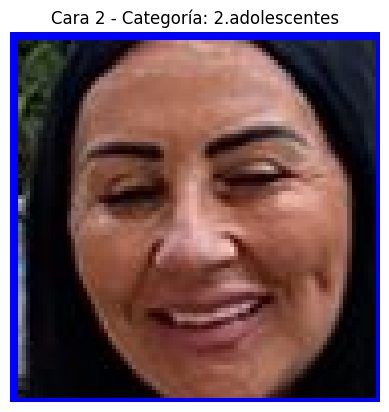

{'output_0': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.11043916, 0.16403586, 0.09885876, 0.06906807, 0.12561075,
        0.4319874 ]], dtype=float32)>}


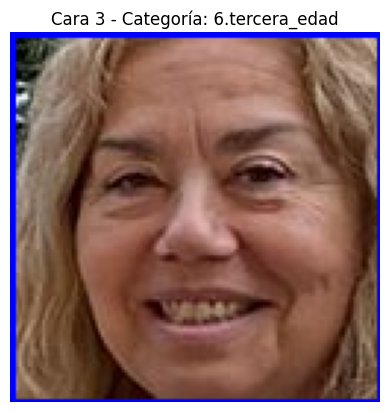

In [28]:
# Detectar y procesar las caras
for i, (x, y, w, h) in enumerate(faces):
    # Recortar la cara de la imagen original
    face = img[y:y+h, x:x+w]

    # Preprocesar la cara para hacer predicciones
    face_preprocessed = preprocess_face(face)  # Asegúrate de normalizar y ajustar el tamaño correctamente
    face_preprocessed = np.expand_dims(face_preprocessed, axis=0)  # Añadir una dimensión para batch_size=1

    # Hacer la predicción con el modelo TFSMLayer
    prediction_dict = custom_model(face_preprocessed)  # El modelo devuelve un diccionario
    prediction = prediction_dict['output_0']  # Extraer el tensor de probabilidades
    prediction = prediction.numpy()  # Convertir a un array de numpy

    # Obtener el índice de la clase con mayor probabilidad
    predicted_class = np.argmax(prediction[0])  # Como prediction tiene forma (1, 6), seleccionamos la primera fila

    # Obtener el nombre de la categoría predicha
    predicted_category = names[predicted_class]  # Mapear el índice a la etiqueta

    # Mostrar la cara usando matplotlib
    plt.figure()
    print(custom_model(face_preprocessed))
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB
    plt.title(f'Cara {i+1} - Categoría: {predicted_category}')
    plt.axis('off')  # Ocultar los ejes
    plt.show()


## Usar modelos guardados como .keras

In [29]:
# Cargar el modelo guardado
custom_model = load_model("models/model_VGG16.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[[0.022769 0.000073 0.000131 0.976957 0.000025 0.000045]]


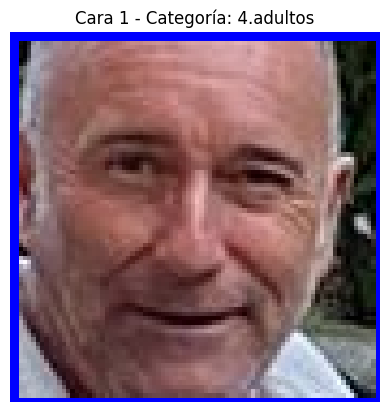

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[[0.01045  0.00031  0.888319 0.099621 0.000626 0.000674]]


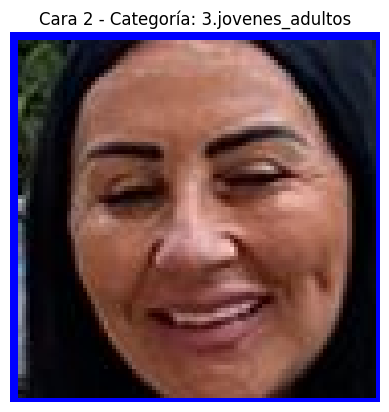

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
[[0.003962 0.421066 0.396701 0.116707 0.047838 0.013726]]


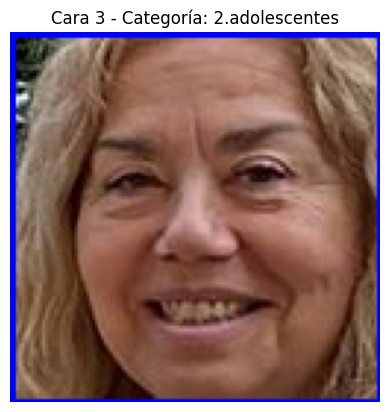

In [ ]:
names = ["1.niños", "2.adolescentes", "3.jovenes_adultos", "4.adultos", "5.adultos_mayores", "6.tercera_edad"]

np.set_printoptions(suppress=True, precision=6)
# Detectar y procesar las caras
for i, (x, y, w, h) in enumerate(faces):
    # Recortar la cara de la imagen original
    face = img[y:y+h, x:x+w]

    # Preprocesar la cara para hacer predicciones
    face_preprocessed = preprocess_face(face)
    #print(face_preprocessed)
    
    
    # Hacer la predicción con el modelo
    prediction = custom_model.predict(face_preprocessed)
    
    # Obtener la clase predicha (categoría) con el índice de mayor probabilidad
    predicted_class = np.argmax(prediction, axis=1)[0]  # Obtener el índice de la clase
    
    # Obtener el nombre de la categoría predicha
    predicted_category = names[predicted_class]

    # Mostrar la cara usando matplotlib
    plt.figure()
    print(custom_model.predict(face_preprocessed))
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB
    plt.title(f'Cara {i+1} - Categoría: {predicted_category}')
    plt.axis('off')  # Ocultar los ejes
    plt.show()

---